## Is there a correlation between price of the appartment and their relative distance to nearest subway stations
<br><br><br>

# **<u>Introduction : Analyse de l’influence des stations de métro sur les prix immobiliers à Shanghai</u>**

Dans ce projet, nous explorons si la distance des appartements aux stations de métro les plus proches à Shanghai a une influence significative sur leur prix au mètre carré. Ce type d’analyse est essentiel pour comprendre comment l’accès aux transports publics peut affecter les dynamiques du marché immobilier.

### <u>Objectifs</u>

Le projet vise à répondre à la question suivante : Existe-t-il une corrélation entre le prix des appartements et leur distance aux stations de métro à Shanghai ?

Pour ce faire, nous adoptons une approche méthodique en suivant les étapes suivantes :
1. **<u>Chargement et nettoyage des données</u>**
	* Importation des données immobilières (Anjuke) et des points d’intérêt (stations de métro).
	* Nettoyage et transformation des données pour assurer leur compatibilité avec l’analyse géospatiale.
2.	**<u>Analyse exploratoire des données (EDA)</u>**
	* Visualisation des données pour identifier les tendances et relations potentielles.
	* Restriction des données à la région de Shanghai à l’aide de filtres géographiques.
3. **<u>Calcul des distances minimales</u>**
	* Calcul de la distance minimale entre chaque appartement et la station de métro la plus proche en utilisant des algorithmes géométriques (e.g., BallTree).
4.	**<u>Modélisation et régression linéaire</u>**
	* Construction d’un modèle de régression linéaire pour évaluer l’influence de la proximité d’une station de métro sur le prix au mètre carré.
	* Comparaison des approches pour minimiser le coût (e.g., Mean Squared Error).
5.	**<u>Conclusion</u>**
	* Interprétation des résultats pour comprendre l’impact des stations de métro sur les prix immobiliers.
	* Identification des limites du modèle et pistes d’amélioration futures.

Portée et Applications

Les résultats de cette étude peuvent être utiles aux urbanistes, promoteurs immobiliers et décideurs politiques pour planifier l’aménagement urbain ou estimer l’impact économique des projets de transport.
<br><br><br><br><br><br><br><br>

### 1 import stuff
#### <u>Importation des bibliothèques nécessaires :</u>
- pandas : pour la manipulation des données tabulaires.
- geopandas : pour l'analyse et la manipulation des données géospatiales.
- seaborn : pour la visualisation des données avec des graphiques stylisés.
- math et numpy : pour les calculs mathématiques et numériques.
- matplotlib.pyplot : pour la création de graphiques personnalisés.
- sklearn.neighbors.BallTree : pour effectuer des calculs efficaces de distances minimales.

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

sns.set_style("white",rc={"figure.figsize":(10, 10)})

### 2 work with anjuke data

Importation du dataset Anjuke (données immobilières)<br>
Le fichier contient des informations sur les appartements, comme le prix, la surface, et la localisation (longitude, latitude).

In [9]:
raw_anjuke = pd.read_pickle('data/utseus-anjuke-real-estate.pk')

In [15]:
!pwd

/Users/alexandre/Documents/ecole/UTC/A24 - Shanghai/Advanced Data Analysis/2 - Cours/TD


In [ ]:
raw_anjuke


In [18]:
anjuke_df = pd.DataFrame(raw_anjuke[1:],columns=raw_anjuke[0], )

all of the field we see in the columns are object and have not been correctly imported as numbers. 

All numeric columns shall transformed into floats using pandas to_numeric function.

In [19]:
anjuke_df[anjuke_df.columns[2:-4]] = anjuke_df[anjuke_df.columns[2:-4]].apply(pd.to_numeric)

Conversion du DataFrame pandas en GeoDataFrame GeoPandas
Cette étape est nécessaire pour utiliser des outils d'analyse géospatiale.
Les colonnes longitude et latitude sont utilisées pour créer une géométrie de type "point".

In [20]:
anjuke_gdf = gpd.GeoDataFrame(anjuke_df, 
                              geometry=gpd.points_from_xy(anjuke_df.longitude, anjuke_df.latitude),
                              crs=4326
                             )

Visualisation initiale des points sur une carte. Chaque point représente un appartement.

<Axes: >

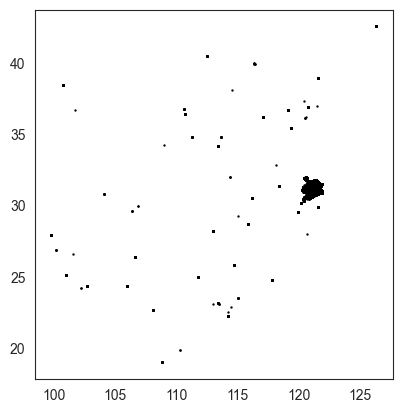

In [21]:
anjuke_gdf.plot(color='black', markersize=.5)

#### <u>Conclusion préliminaire</u>

Nous constatons une forte concentration de points représentant des appartements dans une zone précise, qui correspond à la région de Shanghai. Les autres points, en revanche, représentent des appartements situés en dehors de Shanghai.

Ces points situés hors de Shanghai posent un problème pour notre analyse, car ils constituent des outliers. En l’état, ces valeurs extrêmes risquent de fausser notre régression linéaire, la rendant non représentative des données de Shanghai.

#### <u>Nouvel objectif</u>

*Éliminer les outliers pour garantir une analyse fiable et cohérente.*
<br><br><br><br><br>

Première méthode de filtrage : Cela se fait en restreignant les données à une boîte géographique correspondant à Shanghai.

<Axes: >

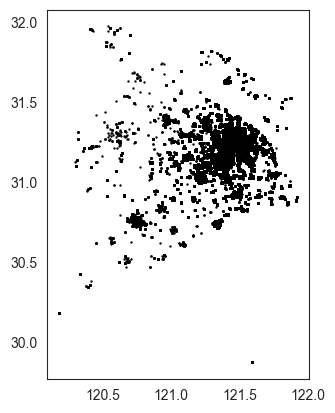

In [23]:
anjuke_gdf.cx[118.481096:124.924577,29.673589:32.412286].plot(color='black', markersize=.5)
#on filtre uniquement sur la zone qui ns intéresse qui est ici shanghai, et pour faire ca on fait un .cx[xmin:xmax,ymin:ymax]

Deuxième méthode de filtrage : utiliser la carte de Shanghai pour vérifier quels appartements s'y trouvent

In [ ]:
shanghai = gpd.read_file('0-上海行政区划地图/区县.shp') 
#la deuxieme méthode est de récupérer la carte de la ville de shanghai et demander aux points de notre dataframe de se positionner sur cette carte

<Axes: >

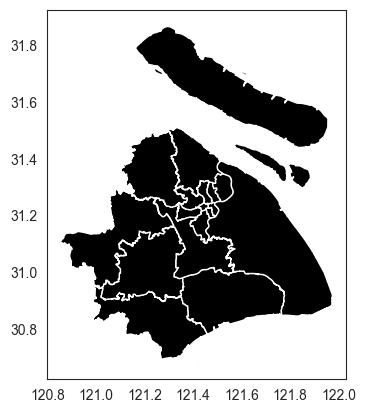

In [ ]:
shanghai.plot(color='black', markersize=.5)

In [ ]:
print(f'before {len(anjuke_gdf)}')
anjuke_filtershp_gdf = gpd.sjoin(anjuke_gdf, shanghai, predicate='within')
print(f'after {len(anjuke_filtershp_gdf)}')

before 467029
after 451192


<Axes: >

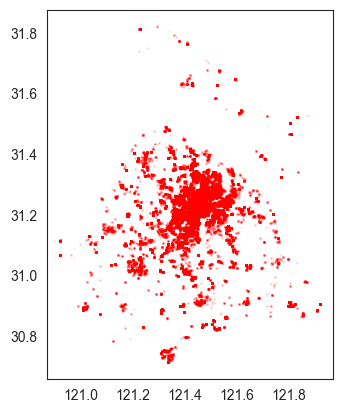

In [ ]:
anjuke_filtershp_gdf.plot(color='red', markersize=.5, alpha=.01)

#### Conclusion après filtrage

Après avoir appliqué le filtre géographique, nous avons éliminé les points situés en dehors de Shanghai. Désormais, notre jeu de données se concentre uniquement sur les appartements localisés dans cette région.

Ce nettoyage est une étape essentielle, car il garantit que notre analyse sera pertinente et représentative des dynamiques immobilières de Shanghai. Nous avons ainsi réduit le risque d’introduire des biais liés à des valeurs aberrantes, rendant notre modèle plus fiable pour les étapes suivantes.
<br><br><br>

### 3 work with POI subway stations

Nous commençons par charger les données de points d’intérêt (POI) qui incluent des informations sur les stations de métro de Shanghai. 

In [25]:
poi_df = pd.read_csv('data/shanghaiPOI2017.csv',delimiter=';', decimal=',', low_memory=False)

In [27]:
subway_df = poi_df[poi_df.GBCODE==200402]

Nous transformons ensuite le DataFrame des stations de métro en un GeoDataFrame à l’aide de la bibliothèque GeoPandas. Les coordonnées GPS des stations (en X et Y) sont converties en géométrie de type Point, ce qui nous permet de travailler avec des données géospatiales et de les visualiser sur une carte.

In [36]:
subway_gdf = gpd.GeoDataFrame(subway_df, 
                              geometry=gpd.points_from_xy(subway_df.GPSX, subway_df.GPSY),
                              crs=4326
                             )

<Axes: >

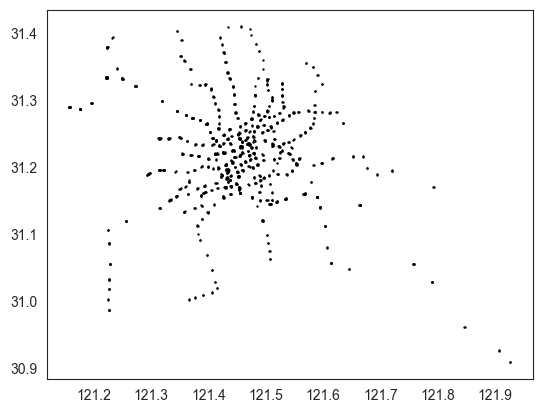

In [37]:
subway_gdf.plot(color='black', markersize=.5)

#### Analyse du graphe
On peut donc voir le réseau de métro de la ville de Shaganghai. A savoir quand même que chaque point que l'on visualise est en réalité plusieur point (chaqeu sortie de métro) <br><br><br>

In [ ]:
subway_gdf

In [ ]:
subway_gdf.to_crs(epsg=4576)

In [40]:
anjuke_filtershp_gdf = anjuke_gdf.to_crs(epsg=4576)


#### Calcul de la distance minimal entre les appartements et la station de métro la plus proche


Dans cette première version, nous calculons la distance entre chaque appartement et chaque station de métro en utilisant des boucles imbriquées. Pour chaque appartement, nous parcourons toutes les stations de métro, calculons la distance Euclidienne et conservons la distance minimale. Bien que fonctionnelle, cette méthode est très lente car elle implique une double boucle pour chaque appartement et chaque station de métro. Cela devient un problème de performance lorsque les ensembles de données sont volumineux.

In [ ]:
%%timeit

for i, row in anjuke_filtershp_gdf.iterrows():
    x1, y1 = row['geometry'].xy
    print("this is your current apartment location : ", x1[0], y1[0])
    distances=[]
    for j, row2 in subway_gdf.iterrows():
        x2, y2 = row2['geometry'].xy
        print(x2, y2)
        distance = np.sqrt((x1[0] - x2[0])**2 + (y1[0] - y2[0])**2)
        distances.append(distance)
    
    distance = min(distances)
    print("this is the min distance to the closest subway station: ", distance)
    break

# L'idée est ici est plutôt d'aller beaucoup plus vite et d'éviter les loops qui prennent beaucoup de temps.
# On va plutôt passer par des vecteurs et des matrices.

Dans cette deuxième version, nous remplaçons les boucles imbriquées par un calcul vectorisé des distances. Nous créons un tableau contenant toutes les coordonnées des stations de métro et calculons les distances entre chaque appartement et toutes les stations simultanément, en utilisant des opérations sur des matrices. Cela permet de réduire le temps de calcul en évitant la double boucle, et améliore ainsi l’efficacité de l’algorithme.

In [ ]:
%%time

#on créer un vecteur colonne de tous les coordonnées des arrêts de métro, et on calcule la distance pour chaque points de nos apart, et on garde le min --> on supprime une loop
x = subway_gdf.geometry.x
y = subway_gdf.geometry.y
points = np.array(list(zip(x,y)))

nearests = []

for i,r in anjuke_filtershp_gdf.iterrows():
    x = r.geometry.x
    y = r.geometry.y
    single_point = np.array([x, y])
    
    distances = np.sum((points - single_point)**2, axis=1)
    distance = np.sqrt(np.min(distances))
    nearests.append(distance)

anjuke_filtershp_gdf['nearest_BF_2'] = nearests

Dans cette troisième version, nous utilisons la fonction apply() pour appliquer le calcul de la distance minimale à chaque appartement de manière plus propre et concise, au lieu de recourir à une boucle for. De plus, nous intégrons l’index spatial (sindex) de GeoPandas, qui permet d’effectuer des recherches de voisins les plus proches de manière beaucoup plus rapide et optimisée. L’utilisation de sindex accélère considérablement les requêtes de voisinage, en réduisant le nombre de comparaisons nécessaires pour chaque appartement, et nous permet d’effectuer ces calculs à une vitesse bien plus élevée, même avec un grand nombre de points.

In [ ]:
x = subway_gdf.geometry.x
y = subway_gdf.geometry.y
points = np.array(list(zip(x,y)))

def nearest(x,y):
    single_point = np.array([x, y])
    distances = np.sum((points - single_point)**2, axis=1)
    return np.sqrt(np.min(distances))

anjuke_filtershp_gdf['nearest_apply'] = anjuke_filtershp_gdf.geometry.apply(lambda g: nearest(g.x, g.y))

In [ ]:
%%time

_, nearest = subway_gdf.geometry.sindex.nearest(anjuke_filtershp_gdf.geometry, return_distance=True,return_all=False)
anjuke_filtershp_gdf['nearest_sindex'] = nearest

In [45]:
# Vérifiez et nettoyez les géométries
subway_gdf = subway_gdf[~subway_gdf.geometry.is_empty & subway_gdf.geometry.notna()]
anjuke_filtershp_gdf = anjuke_filtershp_gdf[~anjuke_filtershp_gdf.geometry.is_empty & anjuke_filtershp_gdf.geometry.notna()]

# Vérifiez que toutes les géométries sont des points
assert subway_gdf.geometry.geom_type.isin(['Point']).all(), "Toutes les géométries de subway_gdf doivent être des points valides"
assert anjuke_filtershp_gdf.geometry.geom_type.isin(['Point']).all(), "Toutes les géométries de anjuke_filtershp_gdf doivent être des points valides"

# Extraire les coordonnées des arrêts de métro
x = subway_gdf.geometry.x
y = subway_gdf.geometry.y
points = np.array(list(zip(x, y)))  # Vecteur des coordonnées des arrêts de métro

nearests = []  # Liste pour stocker les distances minimales

# Calculer la distance minimale pour chaque appartement
for i, r in anjuke_filtershp_gdf.iterrows():
    # Extraire les coordonnées de l'appartement
    single_point = np.array([r.geometry.x, r.geometry.y])

    # Calcul des distances à tous les arrêts de métro
    distances = np.sum((points - single_point)**2, axis=1)
    
    # Calcul de la distance minimale
    min_distance = np.sqrt(np.min(distances))
    nearests.append(min_distance)

# Ajouter les distances minimales au DataFrame
anjuke_filtershp_gdf['nearest_BF_2'] = nearests

/var/folders/z4/q146c2fs7bn5pvjc1t0m78z40000gn/T/ipykernel_2404/1358521218.py:3: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  anjuke_filtershp_gdf = anjuke_filtershp_gdf[~anjuke_filtershp_gdf.geometry.is_empty & anjuke_filtershp_gdf.geometry.notna()]
/Users/alexandre/Documents/ecole/UTC/A24 - Shanghai/Advanced Data Analysis/env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### <u>**Conclusion générale :**</u>
À chaque itération, nous avons amélioré la méthode de calcul des distances en remplaçant des boucles coûteuses par des méthodes vectorisées et des optimisations spatiales. Le passage à l’utilisation de l’index spatial sindex et la fonction apply() de pandas ont permis de considérablement accélérer le calcul, et le nettoyage des données a amélioré la robustesse et la qualité des résultats. Grâce à ces optimisations, nous pouvons désormais traiter de grands ensembles de données de manière plus rapide et efficace.
<br><br><br>

## Regarder le balltree avec SK Learn

In [46]:
%%time


x = subway_gdf.geometry.x
y = subway_gdf.geometry.y
subway_points = np.array(list(zip(x,y)))

x = anjuke_filtershp_gdf.geometry.x
y = anjuke_filtershp_gdf.geometry.y
anjuke_points = np.array(list(zip(x,y)))


tree = BallTree(points, leaf_size=2, metric='euclidean')

anjuke_filtershp_gdf['nearest_sklearn'], _ = tree.query(anjuke_points, k=1)

CPU times: user 304 ms, sys: 29 ms, total: 333 ms
Wall time: 358 ms


/Users/alexandre/Documents/ecole/UTC/A24 - Shanghai/Advanced Data Analysis/env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [47]:
anjuke_filtershp_gdf['nearest_BF_2']

0         2.162210e+07
1         2.162771e+07
2         2.162657e+07
3         2.162657e+07
4         2.162904e+07
              ...     
467024    2.162220e+07
467025    2.162378e+07
467026    2.162296e+07
467027    2.162236e+07
467028    2.162116e+07
Name: nearest_BF_2, Length: 463067, dtype: float64

In [ ]:
anjuke_filtershp_gdf.head()

In [48]:
prix_m2 = anjuke_filtershp_gdf['price'] / anjuke_filtershp_gdf['surface']
anjuke_filtershp_gdf['prix_m2'] = prix_m2

anjuke_filtershp_gdf['prix_m2']

/Users/alexandre/Documents/ecole/UTC/A24 - Shanghai/Advanced Data Analysis/env/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0         38666.666667
1         51315.789474
2         58152.173913
3         63970.588235
4         50000.000000
              ...     
467024    59774.436090
467025    42452.830189
467026    55405.405405
467027    55555.555556
467028    49122.807018
Name: prix_m2, Length: 463067, dtype: float64

Text(0, 0.5, 'Prix au m2')

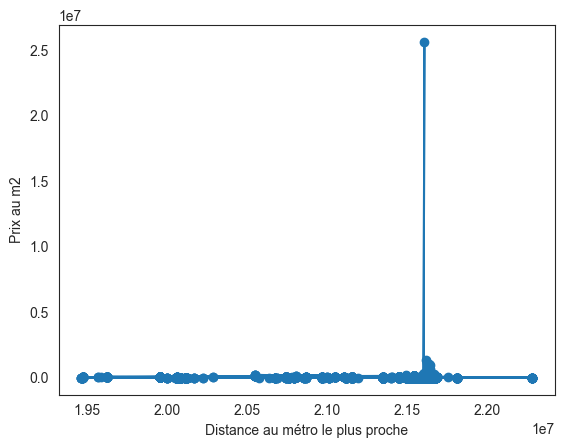

In [57]:
x = anjuke_filtershp_gdf['nearest_sklearn']
y = anjuke_filtershp_gdf['onesquaremeter']

#je veux afficher le graphique de mon prix au m2 en fonction de la distance au métro le plus proche
plt.plot(x, y)
plt.scatter(x, y)
plt.xlabel('Distance au métro le plus proche')
plt.ylabel('Prix au m2')

## Regression

### INTRO

First, we create a new gdf where we'll put our latest data file with the previous work around defining the column nearest subway station

In [2]:
import pyarrow.parquet as pq
new_gdf = gpd.read_parquet('td2-anjuke.pqt')

In [9]:
new_gdf.head()

new_gdf.shape

(451192, 21)

In [10]:
new_gdf.describe()

,longitude,latitude,bedroom,room,surface,price,onesquaremeter,index_right,TYPE,nearest_BF_2,nearest_apply,nearest_sindex,nearest_sklearn
count,451192.000000,451192.000000,451192.000000,451192.000000,451192.000000,4.511920e+05,4.511920e+05,451192.000000,451192.0,451192.000000,451192.000000,451192.000000,451192.000000
mean,121.429329,31.190088,2.334620,1.645266,104.131102,6.853017e+06,5.790093e+04,13.384818,1.0,3517.054117,3517.054117,3517.054117,3517.054117
std,0.131013,0.147096,1.008983,0.614757,87.476855,1.243996e+07,4.837003e+04,5.765400,0.0,6421.505616,6421.505616,6421.505616,6421.505616
min,120.918842,30.713874,1.000000,-1.000000,10.000000,3.000000e+04,7.692308e+02,4.000000,1.0,4.124647,4.124647,4.124647,4.124647
25%,121.379103,31.137351,2.000000,1.000000,58.000000,2.500000e+06,3.741349e+04,8.000000,1.0,423.054293,423.054293,423.054293,423.054293
50%,121.436531,31.215725,2.000000,2.000000,86.000000,4.000000e+06,5.555556e+04,13.000000,1.0,796.687215,796.687215,796.687215,796.687215
75%,121.493975,31.268479,3.000000,2.000000,120.000000,7.700000e+06,7.419355e+04,19.000000,1.0,2338.142086,2338.142086,2338.142086,2338.142086
max,121.919927,31.820748,9.000000,9.000000,4097.000000,1.000000e+09,2.564077e+07,25.000000,1.0,46637.302594,46637.302594,46637.302594,46637.302594


### 0 start with a regression plot

then, we see in our describe we've got the column onesquaremeter, and also the column nearest_sklearn obtained after the balltree method, therefore we'll plot the evolution of the onesquaremeter through the nearest_sklearn and see if there's a potential correlation between those two columns

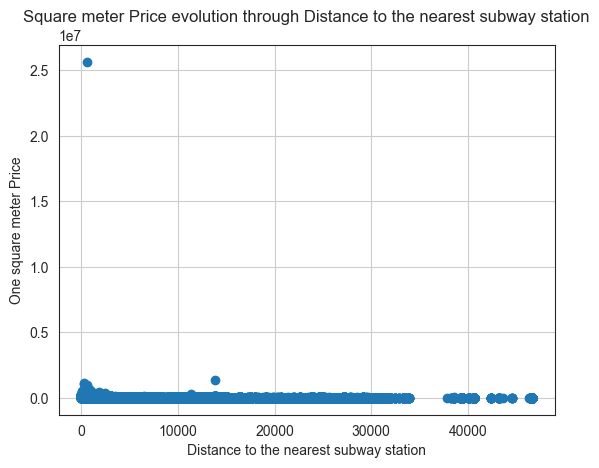

In [42]:
x = new_gdf['nearest_sklearn']
y = new_gdf['onesquaremeter']

# Affichage des données
plt.plot(x, y, 'o')
plt.xlabel('Distance to the nearest subway station')
plt.ylabel('One square meter Price')
plt.title('Square meter Price evolution through Distance to the nearest subway station')
plt.grid()

#### Conclusion

After creating the graph of the price per square meter versus the distance to the nearest metro, we realize that the data cannot be used directly. Indeed, there are outliers both in terms of price and distance.


### 1 outliers

#### 1.1 the interquartile method 

1. calculate the first quartile
2. calculate the third quartile 
3. Using those quartiles calulated IQR.
4. Then using IQR calculated limits for our values to lie in between.
    - iqr = quartile3 - quartile1
    - upper_limit = quartile3 + 1.5 * iqr
    - lower_limit = quartile1 - 1.5 * iqr
5. filter and display length of data

In [4]:
import pandas as pd

def clean_data_with_iqr(data, columns):
    """
    Nettoie les données en supprimant les valeurs aberrantes selon la méthode des IQR.
    
    Parameters:
        data (pd.DataFrame): Le DataFrame contenant les données à nettoyer.
        columns (list): Liste des colonnes sur lesquelles appliquer le nettoyage.

    Returns:
        pd.DataFrame: Les données nettoyées.
        dict: Un dictionnaire contenant les statistiques avant/après nettoyage.
        dict: Un dictionnaire contenant les bornes calculées pour chaque colonne.
    """
    # Copie des données pour éviter de modifier l'original
    cleaned_data = data[columns].copy()
    
    # Initialisation des statistiques
    initial_count = len(cleaned_data)
    
    # Dictionnaire pour stocker les bornes de chaque colonne
    bounds = {}
    
    # Application de la méthode des IQR pour chaque colonne
    for column in cleaned_data.columns:
        Q1 = cleaned_data[column].quantile(0.25)  # Premier quartile
        Q3 = cleaned_data[column].quantile(0.75)  # Troisième quartile
        IQR = Q3 - Q1  # Intervalle interquartile
        
        # Définir les bornes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Stocker les bornes pour la colonne
        bounds[column] = {"lower_bound": lower_bound, "upper_bound": upper_bound}
        
        # Filtrer les données
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)]
    
    # Calcul des statistiques
    final_count = len(cleaned_data)
    stats = {
        "initial_count": initial_count,
        "final_count": final_count,
        "percentage_retained": (final_count / initial_count) * 100,
        "percentage_removed": 100 - (final_count / initial_count) * 100
    }
    
    return cleaned_data, stats, bounds

# Utilisation de la méthode
columns_to_clean = ['nearest_sklearn', 'onesquaremeter']
cleaned_gdf, stats, bounds = clean_data_with_iqr(new_gdf, columns_to_clean)

# Affichage des statistiques
print(f"Nombre of data pre cleaning : {stats['initial_count']}")
print(f"Nb of Data post cleaning : {stats['final_count']}")
print(f"Conserved Data Percentage : {stats['percentage_retained']:.2f}%")
print(f"Deleted Data Percentage : {stats['percentage_removed']:.2f}%")

# Affichage des bornes pour chaque colonne
for column, bound in bounds.items():
    print(f"\nColumn : {column}")
    print(f"  Lower bound : {bound['lower_bound']:.2f}")
    print(f"  Upper bound : {bound['upper_bound']:.2f}")

Nombre of data pre cleaning : 451192
Nb of Data post cleaning : 361882
Conserved Data Percentage : 80.21%
Deleted Data Percentage : 19.79%

Column : nearest_sklearn
  Lower bound : -2449.58
  Upper bound : 5210.77

Column : onesquaremeter
  Lower bound : -2400.85
  Upper bound : 127458.21


### Cleaned Data

After applying the IQR method to clean the data, we retained 80.21% of the original dataset, removing 19.79% of the data as outliers. Interestingly, the lower bound did not remove any data points, as all values in the dataset are positive, meaning that the lower bound was not a significant factor in the cleaning process.

We saved those data into a new gdf named cleaned_gdf, and we'll use it for our further studies

### RESULTS OF THE IQR

We can now plot our cleaned data and see how does it affects our gdf.

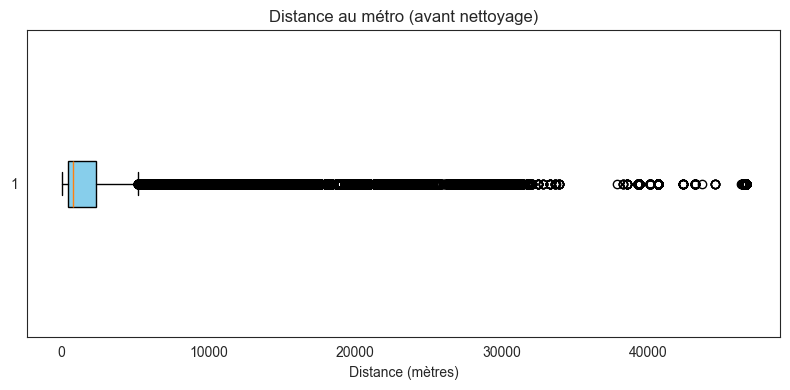

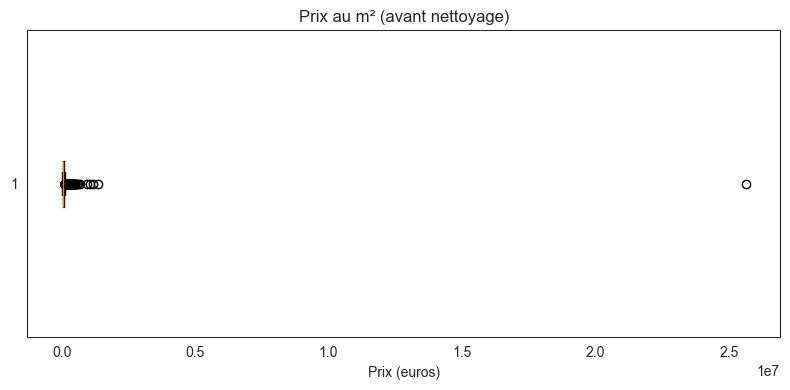

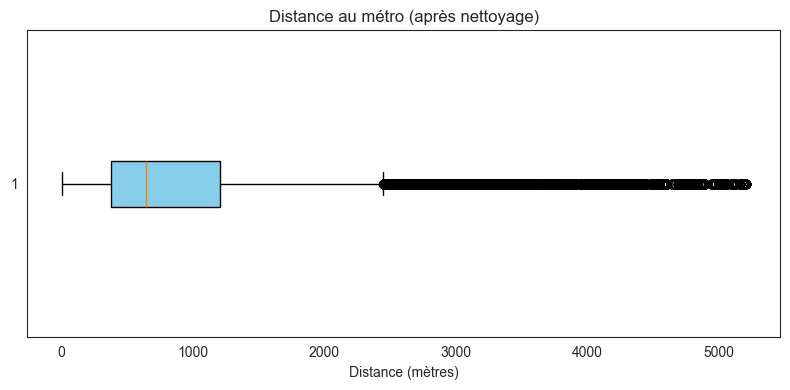

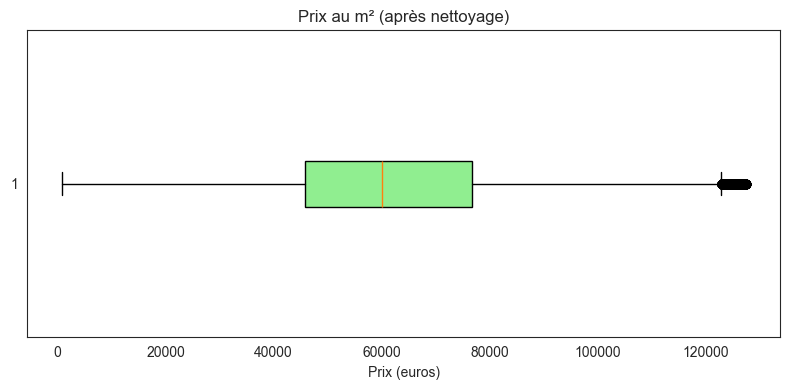

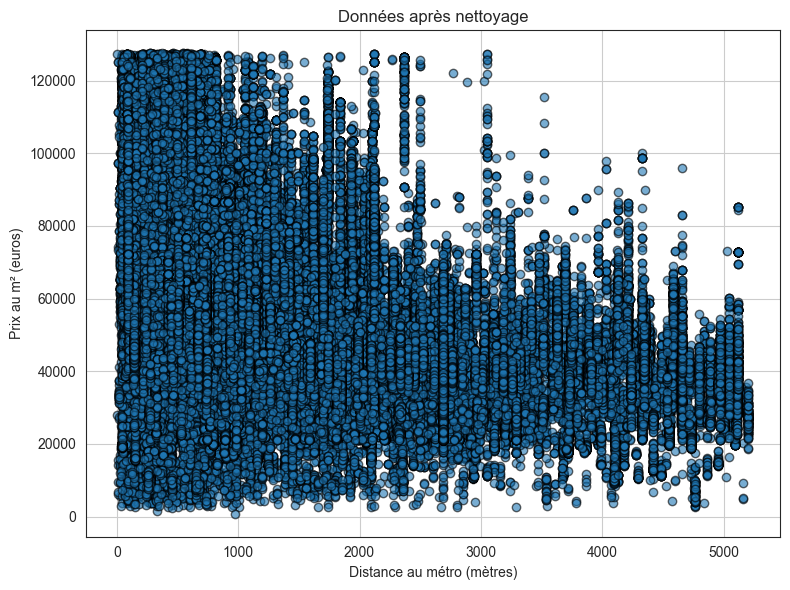

In [5]:
import matplotlib.pyplot as plt

# Visualisation des boîtes à moustaches avant nettoyage
plt.figure(figsize=(8, 4))
plt.boxplot(new_gdf['nearest_sklearn'], vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title("Distance au métro (avant nettoyage)")
plt.xlabel("Distance (mètres)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.boxplot(new_gdf['onesquaremeter'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.title("Prix au m² (avant nettoyage)")
plt.xlabel("Prix (euros)")
plt.tight_layout()
plt.show()

# Visualisation des boîtes à moustaches après nettoyage
plt.figure(figsize=(8, 4))
plt.boxplot(cleaned_gdf['nearest_sklearn'], vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title("Distance au métro (après nettoyage)")
plt.xlabel("Distance (mètres)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.boxplot(cleaned_gdf['onesquaremeter'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.title("Prix au m² (après nettoyage)")
plt.xlabel("Prix (euros)")
plt.tight_layout()
plt.show()

# Scatter plot des données nettoyées
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_gdf['nearest_sklearn'], cleaned_gdf['onesquaremeter'], alpha=0.6, edgecolors='k')
plt.title("Données après nettoyage")
plt.xlabel("Distance au métro (mètres)")
plt.ylabel("Prix au m² (euros)")
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
cleaned_gdf.describe()

,nearest_sklearn,onesquaremeter
count,361882.000000,361882.000000
mean,997.808513,61912.195233
std,978.036083,23190.726441
min,4.124647,769.230769
25%,375.512237,45882.352941
50%,642.912573,60000.000000
75%,1204.095707,76712.328767
max,5204.689025,127454.545455


### Delete the outliers With the 3 Standard Deviations

Number of data before cleaning: 451192
Number of data after cleaning: 434520
Conserved Data Percentage: 96.30%
Deleted Data Percentage: 3.70%

Column: nearest_sklearn
  Lower bound: -15747.46
  Upper bound: 22781.57

Column: onesquaremeter
  Lower bound: -86396.50
  Upper bound: 205202.17


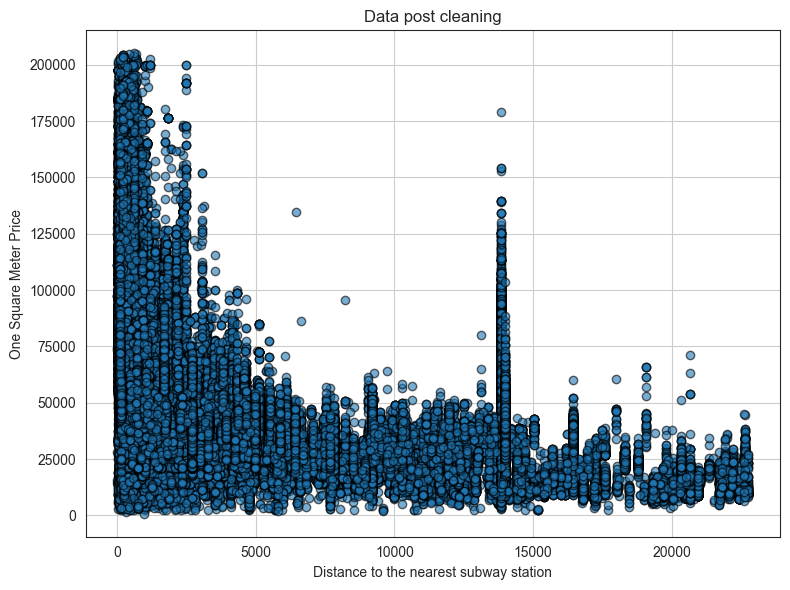

In [8]:
import pandas as pd
import numpy as np

def clean_data_with_std(data, columns):
    """
    Cleans data by removing outliers using the 3 standard deviations method (based on Normal Distribution).
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data to clean.
        columns (list): List of columns to apply the cleaning.

    Returns:
        pd.DataFrame: Cleaned data.
        dict: Dictionary containing statistics before and after cleaning.
        dict: Dictionary containing the calculated bounds for each column.
    """
    # Copy the data to avoid modifying the original one
    cleaned_data = data[columns].copy()
    
    # Initializing statistics
    initial_count = len(cleaned_data)
    
    # Dictionary to store the bounds for each column
    bounds = {}
    
    # Applying the 3 standard deviations method for each column
    for column in cleaned_data.columns:
        mean = cleaned_data[column].mean()  # Mean of the column
        std_dev = cleaned_data[column].std()  # Standard deviation of the column
        
        # Calculate the upper and lower bounds
        lower_bound = mean - 3 * std_dev
        upper_bound = mean + 3 * std_dev
        
        # Store the bounds for the column
        bounds[column] = {"lower_bound": lower_bound, "upper_bound": upper_bound}
        
        # Filter the data
        cleaned_data = cleaned_data[(cleaned_data[column] >= lower_bound) & (cleaned_data[column] <= upper_bound)]
    
    # Calculate the statistics
    final_count = len(cleaned_data)
    stats = {
        "initial_count": initial_count,
        "final_count": final_count,
        "percentage_retained": (final_count / initial_count) * 100,
        "percentage_removed": 100 - (final_count / initial_count) * 100
    }
    
    return cleaned_data, stats, bounds

# Using the method
columns_to_clean = ['nearest_sklearn', 'onesquaremeter']
cleaned_gdf2, stats, bounds = clean_data_with_std(new_gdf, columns_to_clean)

# Display the statistics
print(f"Number of data before cleaning: {stats['initial_count']}")
print(f"Number of data after cleaning: {stats['final_count']}")
print(f"Conserved Data Percentage: {stats['percentage_retained']:.2f}%")
print(f"Deleted Data Percentage: {stats['percentage_removed']:.2f}%")

# Display the bounds for each column
for column, bound in bounds.items():
    print(f"\nColumn: {column}")
    print(f"  Lower bound: {bound['lower_bound']:.2f}")
    print(f"  Upper bound: {bound['upper_bound']:.2f}")


# Scatter plot des données nettoyées
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_gdf2['nearest_sklearn'], cleaned_gdf2['onesquaremeter'], alpha=0.6, edgecolors='k')
plt.title("Data post cleaning")
plt.xlabel("Distance to the nearest subway station")
plt.ylabel("One Square Meter Price")
plt.grid()
plt.tight_layout()
plt.show()

The results of the outlier removal using the 3 standard deviations method are not particularly conclusive. While it eliminates some extreme values, it retains a large portion of potentially uncorrelated data (96.3%), which could negatively impact the performance of our linear regression model.

For instance, the calculated bounds for the columns (nearest_sklearn and onesquaremeter) are too broad, allowing the inclusion of many data points that likely deviate from the expected trends (espacially around 14000 meters). This indicates that the method is not stringent enough for our dataset’s characteristics.

As a result, we decided to proceed with the IQR method for outlier removal in this study. The IQR approach proved to be more effective in filtering out irrelevant or extreme values while retaining a higher-quality dataset for further analysis.

## 2. LINEAR REGRESSION METHODS

### Best Linear Regression Research

We're gonna use 3 differents methods for our linear regression.

1 - iterative : Loop Research with the Min MSE found

2 - iterative : convergence through a Gradient descent with epochs and learning rates

3 - Sklearn Model : we'll verify our results with this model and compare our values

### 2.1 Method : LOOP with min MSE Research

### Explanation of Our Algorithm :

For our manual linear regression approach, we defined two intervals using linspace: one for the coefficient beta_0 (the y-intercept, which represents the price per square meter for an apartment potentially located next to a metro station), and the other for beta_1 (the slope of our line equation for y_pred, representing the decrease in price per square meter as the distance from the nearest metro station increases).

To optimize and simplify the calculations, we made the following assumptions:

•	For beta_0: The y-intercept is necessarily positive, with a visually estimated range between 50k and 90k, so there is no need to test other values. The line should start with a value within this interval.

•	For beta_1: The slope is necessarily negative. The further the metro station is, the cheaper the price per square meter should be. Therefore, we started with an interval of negative values for beta_1.

Meilleur Beta_0 (intercept) : 72456.14035087719
Meilleur Beta_1 (pente) : -10.526315789473685
MSE minimal : 431879510.81824154


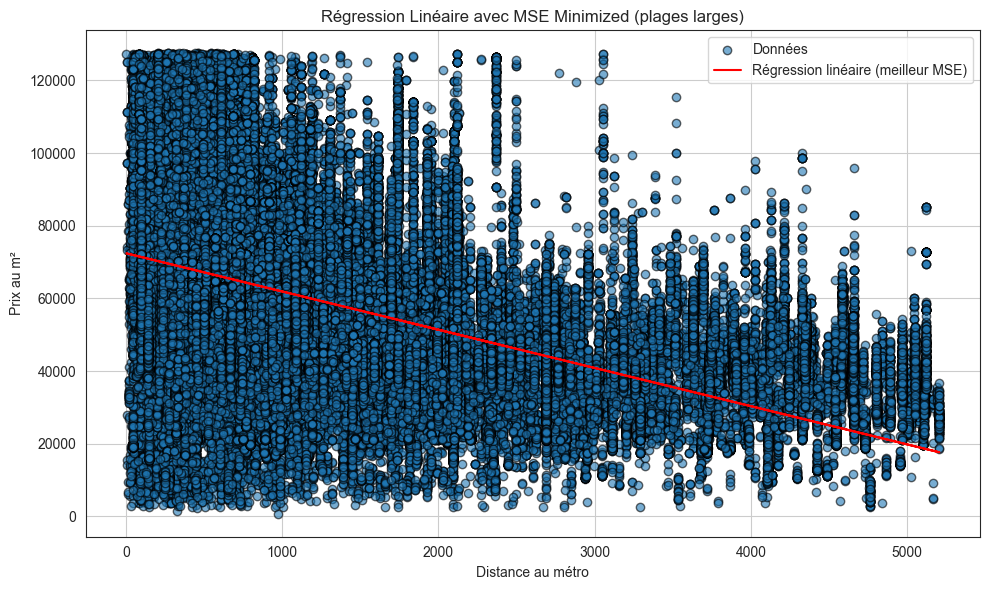

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Extraction des données
x = cleaned_gdf['nearest_sklearn'].values  # Distance au métro
y = cleaned_gdf['onesquaremeter'].values   # Prix au m²

# Plage de valeurs pour beta_0 et beta_1 avec des intervalles plus larges
beta_0_values = np.linspace(50000, 90000, 400)  # Plage pour l'ordonnée à l'origine 
beta_1_values = np.linspace(-50, 0, 400)        # Plage pour la pente 

# Variables pour stocker le MSE minimal et les coefficients associés
min_mse = float('inf')
best_beta_0 = None
best_beta_1 = None

# Boucle sur les différentes valeurs de beta_0 et beta_1
for beta_0 in beta_0_values:
    for beta_1 in beta_1_values:
        # Prédictions en utilisant la droite actuelle
        y_pred = beta_0 + beta_1 * x
        
        # Calcul du MSE (Mean Squared Error)
        mse = np.mean((y - y_pred) ** 2)
        
        # Mise à jour des meilleurs coefficients si le MSE est plus faible
        if mse < min_mse:
            min_mse = mse
            best_beta_0 = beta_0
            best_beta_1 = beta_1

# Affichage des résultats
print(f"Meilleur Beta_0 (intercept) : {best_beta_0}")
print(f"Meilleur Beta_1 (pente) : {best_beta_1}")
print(f"MSE minimal : {min_mse}")

# Prédictions finales avec les meilleurs coefficients
y_pred_final = best_beta_0 + best_beta_1 * x

# Affichage du graphique des résultats
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k', label='Données')
plt.plot(x, y_pred_final, color='red', label='Régression linéaire (meilleur MSE)')

# Ajouter les labels et la légende
plt.title("Régression Linéaire avec MSE Minimized (plages larges)")
plt.xlabel("Distance au métro")
plt.ylabel("Prix au m²")
plt.legend()
plt.grid()

# Affichage du graphique
plt.tight_layout()
plt.show()

## ---------------------------------------------------------------------------------------------------


### 2.2 Method : Gradient Descent and Customized Epochs, Learning Rate Values

Gradient descent is an iterative optimization algorithm used to minimize the mean squared error (MSE) by adjusting the parameters (beta_0 and beta_1) in the direction of the steepest decrease in the cost function. In each iteration (epoch), the gradients of the cost function with respect to each parameter are calculated, and the parameters are updated by subtracting the product of the learning rate and the gradient. This process continues until the MSE converges to a minimum.

### Explanation of Our Algorithm :

In this script, we use gradient descent to optimize the parameters of a linear regression model. The reason we have two different learning rates is that the two coefficients, beta_0 (intercept) and beta_1 (slope), represent different aspects of the regression equation and might require different step sizes for optimal updates. Since the scale of beta_0 and beta_1 can differ, we adjust their learning rates independently to ensure that both parameters converge effectively without one overpowering the other.
Also, we've tested a lot of epochs nb values in order to see the convergence without goign to high in terms of epochs

Epoch 0: MSE=1292527666.12, Beta_0=87945.83, Beta_1=0.24
Epoch 1000: MSE=447322919.11, Beta_0=78019.70, Beta_1=-13.46
Epoch 2000: MSE=434165494.24, Beta_0=74570.49, Beta_1=-11.65
Epoch 3000: MSE=432216681.49, Beta_0=73243.04, Beta_1=-10.96
Epoch 4000: MSE=431928032.98, Beta_0=72732.16, Beta_1=-10.69
Epoch 5000: MSE=431885279.79, Beta_0=72535.55, Beta_1=-10.59
Epoch 6000: MSE=431878947.40, Beta_0=72459.88, Beta_1=-10.55
Epoch 7000: MSE=431878009.47, Beta_0=72430.75, Beta_1=-10.53
Epoch 8000: MSE=431877870.55, Beta_0=72419.55, Beta_1=-10.53
Epoch 9000: MSE=431877849.98, Beta_0=72415.23, Beta_1=-10.52
Epoch 10000: MSE=431877846.93, Beta_0=72413.57, Beta_1=-10.52
Epoch 11000: MSE=431877846.48, Beta_0=72412.93, Beta_1=-10.52
Epoch 12000: MSE=431877846.41, Beta_0=72412.69, Beta_1=-10.52
Epoch 13000: MSE=431877846.40, Beta_0=72412.59, Beta_1=-10.52
Epoch 14000: MSE=431877846.40, Beta_0=72412.56, Beta_1=-10.52

Résultats finaux de la descente de gradient :
Meilleur Beta_0 (intercept) : 72412.5

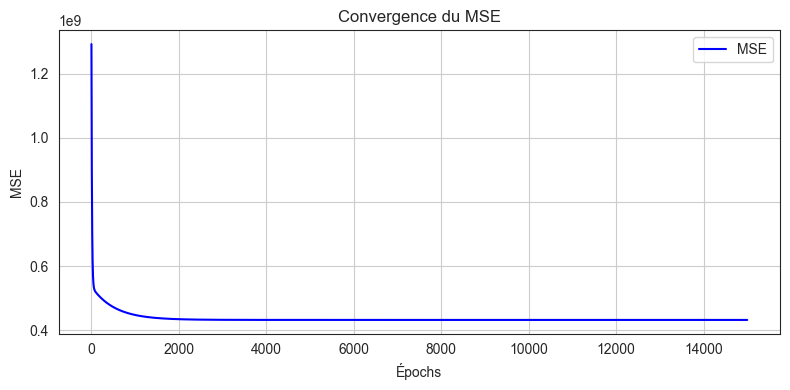

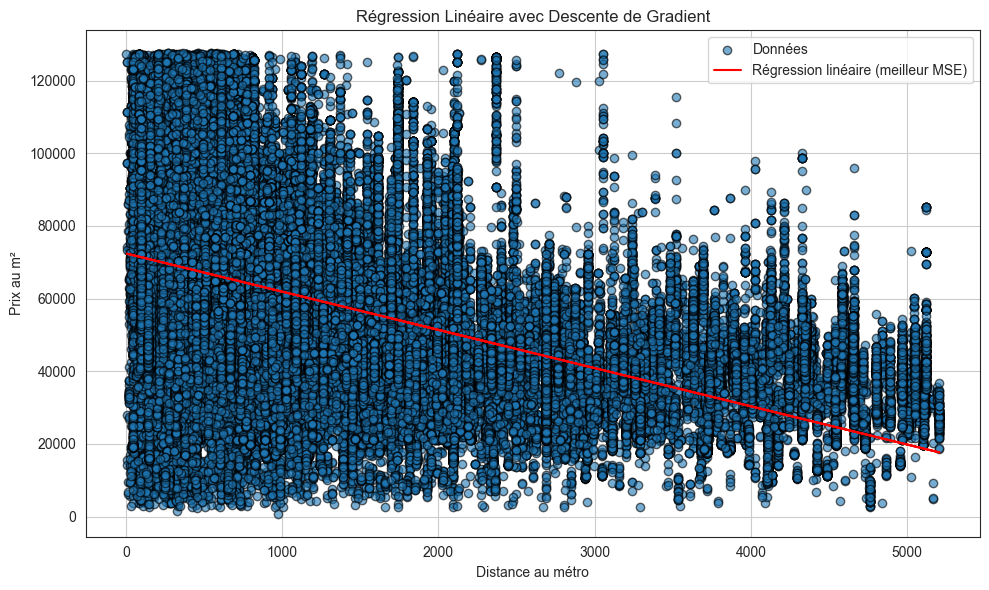

In [12]:
# Initialisation des paramètres
beta_0 = 88000  # Intercept initial
beta_1 = 1      # Pente initiale
learning_rate_b0 = 1e-3  # Taux d'apprentissage pour Beta_0
learning_rate_b1 = 1e-8  # Taux d'apprentissage pour Beta_1
epochs = 15000           # Nombre d'itérations

# Extraction des données
x = cleaned_gdf['nearest_sklearn'].values  # Distance au métro
y = cleaned_gdf['onesquaremeter'].values   # Prix au m²

# Historique des valeurs pour visualisation
history_mse = []
history_b0 = []
history_b1 = []

# Descente de gradient
for epoch in range(epochs):
    # Calcul des prédictions
    y_pred = beta_0 + beta_1 * x
    
    # Calcul des résidus
    residuals = y - y_pred
    
    # Calcul des gradients
    gradient_b1 = -2 * np.sum(x * residuals) / len(x)
    gradient_b0 = -2 * np.sum(residuals) / len(x)
    
    # Mise à jour des coefficients
    beta_1 = beta_1 - learning_rate_b1 * gradient_b1
    beta_0 = beta_0 - learning_rate_b0 * gradient_b0
    
    # Calcul du MSE pour suivre la performance
    mse = np.mean(residuals**2)
    history_mse.append(mse)
    history_b0.append(beta_0)
    history_b1.append(beta_1)
    
    # Affichage périodique pour vérifier l'évolution
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: MSE={mse:.2f}, Beta_0={beta_0:.2f}, Beta_1={beta_1:.2f}")

# Prédictions finales avec les meilleurs coefficients
y_pred_final = beta_0 + beta_1 * x

# Résultats finaux
print("\nRésultats finaux de la descente de gradient :")
print(f"Meilleur Beta_0 (intercept) : {beta_0:.2f}")
print(f"Meilleur Beta_1 (pente) : {beta_1:.2f}")
print(f"MSE final : {mse:.2f}")


# Historique du MSE
plt.figure(figsize=(8, 4))
plt.plot(range(epochs), history_mse, label="MSE", color="blue")
plt.title("Convergence du MSE")
plt.xlabel("Épochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


# Ajouter les labels et la légende
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k', label='Données')
plt.plot(x, y_pred_final, color='red', label='Régression linéaire (meilleur MSE)')
plt.title("Régression Linéaire avec Descente de Gradient")
plt.xlabel("Distance au métro")
plt.ylabel("Prix au m²")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## ---------------------------------------------------------------------------------------------------


### 2.3 Method : For Verification - Using Sklearn Linear Regression Model

We've also implement a linear regression with Skealern model.

Intercept (b0): 72412.53511526213
Coefficient (b1): -10.523401780143866
Mean Squared Error: 431877846.4000813
R² Score: 0.19696694711842655


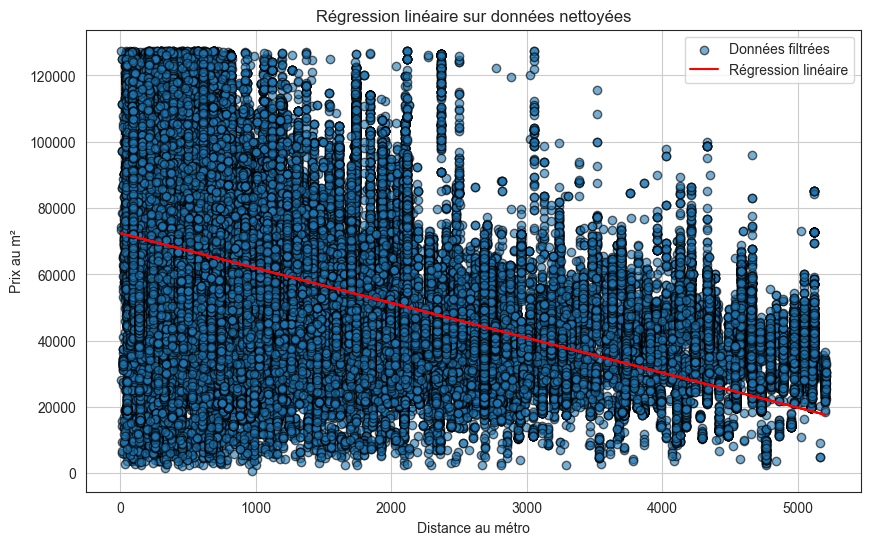

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extraction des données nettoyées
x = cleaned_gdf['nearest_sklearn'].values.reshape(-1, 1)  # Variable indépendante
y = cleaned_gdf['onesquaremeter'].values  # Variable dépendante

# Modèle de régression
model = LinearRegression()
model.fit(x, y)

# Prédictions
y_pred = model.predict(x)

# Affichage des coefficients
print(f"Intercept (b0): {model.intercept_}")
print(f"Coefficient (b1): {model.coef_[0]}")

# Évaluation du modèle
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Visualisation de la régression linéaire
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k', label='Données filtrées')
plt.plot(x, y_pred, color='red', label='Régression linéaire')
plt.title("Régression linéaire sur données nettoyées")
plt.xlabel("Distance au métro")
plt.ylabel("Prix au m²")
plt.legend()
plt.grid()
plt.show()

We can verify the result of our linear regression obtained through the script above by using sklearn and importing the linear regression model.

We obtain the same values, which is reassuring and reinforces the validity of our results for the cleaned gdf.

## ---------------------------------------------------------------------------------------------------

## 3. Let’s calculate the standard error to assess the uncertainty related to our results.

#### std err on the slope beta1

Can we trust this slope coefficient that we found 

Lets implement slide 46 and get the standard error for beta1

In [29]:
# Calcul de la moyenne de x
x_mean = np.mean(x)
print(f"Moyenne de x : {x_mean:.4f}")

# Calcul des prédictions
y_pred = beta_0 + beta_1 * x

# Calcul des résidus
residuals = y - y_pred

# Calcul de la variance résiduelle (sigma^2)
sigma_squared = np.sum(residuals**2) / (len(x) - 2)

# Calcul de la somme des carrés des écarts pour x
sum_squared_x = np.sum((x - x_mean)**2)

# Calcul de l'erreur standard de beta_1
std_err_b1 = np.sqrt(sigma_squared / sum_squared_x)
print(f"Erreur standard de beta_1 : {std_err_b1:.4f}")

Moyenne de x : 997.8085
Erreur standard de beta_1 : 0.0353


## -------------------------------------------

write down the normal law of the distribution of beta1 $N(mean, std)$

### Law Distribution of $Beta_1$ : $N(-10.52, 0.0353)$

## -------------------------------------------

lets get the t-score : how many standard variation away from the mean is our beta1

t_score = beta1 / stderr_beta1

from the scipy stat module, create a normal distribution with the parameters above and calculate the probability density function for the null hypothesis (H0: distance has no influence whatsoever on the price). This will give you the p-value of your beta1. 

is your slope ok? what to conclude?

In [38]:
from scipy import stats

# Given values
beta_1 = -10.5234  # Estimated slope
stderr_beta_1 = 0.0353  # Standard error of beta_1

# 1. Calculate the t-score
t_score = beta_1 / stderr_beta_1
print(f"T-score: {t_score:.2f}")

# 2. Create a normal distribution for the null hypothesis (H0: beta_1 = 0)
# We are assuming the distribution of beta_1 under H0 is centered at 0 with a standard deviation of stderr_beta_1
p_value = stats.norm.cdf(t_score)  # CDF of the normal distribution gives the p-value for one side
p_value = 2 * min(p_value, 1 - p_value)  # Two-tailed test, so we multiply by 2
print(f"P-value: {p_value:.10f}")

# 3. Conclusion
if p_value < 0.05:
    print("Conclusion: The slope is statistically significant, and we can reject the null hypothesis.")
else:
    print("Conclusion: The slope is not statistically significant, and we fail to reject the null hypothesis.")

T-score: -298.11
P-value: 0.0000000000
Conclusion: The slope is statistically significant, and we can reject the null hypothesis.


## -------------------------------------------

### Conclusion With the T-Score and the P-Value
The T-score of -298.11 shows that the estimated slope is significantly different from zero, confirming the strong negative relationship between the price per square meter and the distance to the metro station.

Furthermore, The extremely low P-value of 0.00 indicates that the null hypothesis (that distance has no influence on price) can be rejected with high confidence. 
--> It is almost impossible that the feature wouldn't be correlated with the target
variable
--> The relationship between the price per square meter and the distance from the nearest subway station is statistically significant

## -------------------------------------------

### Conclusion on the slope : $Beta_1$

The regression model shows a statistically significant relationship between the distance to the metro and the price per square meter, with a negative slope. Although the R² is low, indicating that the model only explains a small portion of the variation, the t-test and p-value confirm that the distance to the metro has a meaningful impact on the price. Thus, we can conclude that the proximity to a metro station does influence property prices in Shanghai, but additional factors should be considered to improve the model’s predictive power.

## -------------------------------------------

# 4. <u>**General Conclusion of the Study**</u>


### Context 

This study analyzes the correlation between the price per square meter of properties in Shanghai and their distance to the nearest metro station. Using linear regression, we explored this relationship to determine how much the proximity to a metro station can explain property prices in the city.

The results show a negative relationship between distance to the metro and price per square meter. However, several factors emerged from this analysis that can deepen the study and improve the accuracy of the model:

### Model Performance Analysis

• Mean Squared Error (MSE): The MSE value is 431,883,673.81. In a perfect regression, the MSE would tend towards zero (meaning the predictions would perfectly match the actual values). A high MSE indicates that the model lacks performance and/or that our real-world data cannot be fully explained by simple linear regression.

• R² (Coefficient of Determination): The R² value is 0.197, meaning that only 19.7% of the variation in the price per square meter can be explained by the distance to the metro. This suggests that the model is weak, and other factors should be considered to better explain variations in property prices in Shanghai.

### Model Performance and Statistical Significance

While the linear regression reveals a negative relationship between the price per square meter and the distance to the metro station, it is crucial to assess the statistical significance of the estimated slope (Beta₁).

•	Beta₁ (Slope): The estimated slope is -10.52, indicating that for every 1 km increase in distance from the metro station, the price per square meter decreases on average by 10.52 kRMB.

•	Standard Error of Beta₁: The standard error of Beta₁ is 0.0353, which is relatively small, suggesting that the estimate of the slope is precise and not prone to large fluctuations. A smaller standard error indicates higher reliability in the estimation.

•	T-Score: The t-score for Beta₁ is -298.11, which tells us how many standard deviations the estimated Beta₁ is away from zero. Given the large magnitude of the t-score (far beyond typical threshold values like 1.96), this further indicates that the estimated slope is significantly different from zero.

•	P-Value: The p-value associated with Beta₁ is extremely small (0.0000000000), well below the conventional significance level of 0.05. This means that the null hypothesis (H₀: distance has no influence on price) can be confidently rejected, confirming that the distance to the metro station has a statistically significant impact on the price per square meter of properties in Shanghai.

Conclusion on Statistical Significance:

Given the small standard error, large t-score, and extremely low p-value, we can confidently conclude that the estimated slope is statistically significant. This means that distance to the metro does have a measurable and reliable impact on property prices. Therefore, we can reject the null hypothesis and assert that the relationship between distance to the metro and price per square meter is not due to random chance.

### Potential Areas for Improvement :

Incorporating Additional Variables in a Simple Linear Regression: One major limitation of the current model is that it only takes the distance to the metro station into account. 

In reality, several other factors significantly influence the price per square meter, which should be considered for a more robust analysis :

-	Proximity to the City Center: The distance to the city center is a crucial factor, as properties in central neighborhoods tend to be more expensive, regardless of their proximity to the metro.

-	Housing Characteristics: Variables such as apartment size, building age, neighborhood type, and overall quality of life in the area all contribute to price variations and should be integrated into the model.

-	Access to Other Services: The proximity of essential services like shops, schools, hospitals, parks, etc., also plays a key role in determining property prices.

Multiple Linear Regression Models: Simple linear regression does not allow us to account for multiple factors at the same time. By testing other relevant variables mentioned above, we could select the most correlated ones and perform a multiple linear regression. Furthermore, exploring more advanced statistical techniques, such as random forests, could provide valuable insights, and evaluating the performance of these models could enhance the robustness of the predictions.

Residual Analysis and Error Review: An important aspect of model evaluation is analyzing the residuals—the differences between the actual and predicted values. If residuals display systematic patterns, this indicates that the model is failing to capture certain trends or relationships, suggesting the need for further explanatory variables or adjustments to the model structure.

Final Thoughts:

While our linear regression model has revealed a truly negative relationship between the price per square meter of properties in Shanghai and their distance from the metro station (verified through the P-Value), the current model has shown limited performance, with a relatively low R² score and high MSE. These results suggest that important explanatory variables are missing, and incorporating additional factors would likely improve the predictive accuracy of the model.
